In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import folium
from folium.plugins import HeatMap
import seaborn as sns

In [2]:
ch = pd.read_csv('datasets//Chicago_Crimes.csv')

In [3]:
pd.set_option('display.max_columns', None)
ch

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,13439321,JH237424,04/14/2024 12:00:00 AM,040XX S PRAIRIE AVE,0890,THEFT,FROM BUILDING,APARTMENT,False,False,213,2,3,38.0,06,1178707.0,1878256.0,2024,12/21/2024 03:40:46 PM,41.821236,-87.619921,"(41.821236024, -87.619920712)"
1,13437420,JH234779,04/14/2024 12:00:00 AM,023XX W CERMAK RD,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,COMMERCIAL / BUSINESS OFFICE,False,False,1034,10,25,31.0,26,1161210.0,1889347.0,2024,12/21/2024 03:40:46 PM,41.852052,-87.683801,"(41.852051675, -87.683800849)"
2,13428676,JH224478,04/14/2024 12:00:00 AM,043XX W LE MOYNE ST,0917,MOTOR VEHICLE THEFT,"CYCLE, SCOOTER, BIKE WITH VIN",STREET,False,False,2534,25,36,23.0,07,1146960.0,1909501.0,2024,12/21/2024 03:40:46 PM,41.907640,-87.735587,"(41.907640473, -87.735587478)"
3,13429357,JH225293,04/14/2024 12:00:00 AM,039XX W ADAMS ST,143A,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,STREET,True,False,1122,11,28,26.0,15,1150158.0,1898721.0,2024,12/21/2024 03:40:46 PM,41.877997,-87.724121,"(41.877997275, -87.724120826)"
4,13430098,JH226395,04/14/2024 12:00:00 AM,011XX W 112TH PL,0890,THEFT,FROM BUILDING,RESIDENCE,False,False,2234,22,21,75.0,06,1170856.0,1830157.0,2024,12/21/2024 03:40:46 PM,41.689421,-87.650123,"(41.6894214, -87.650123247)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249118,13805239,JJ217509,04/12/2025 12:00:00 AM,029XX W LOGAN BLVD,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,APARTMENT,False,False,1414,14,1,22.0,26,1156478.0,1917149.0,2025,04/19/2025 03:41:24 PM,41.928440,-87.700416,"(41.928439867, -87.700415972)"
249119,13804023,JJ215813,04/12/2025 12:00:00 AM,094XX S HARVARD AVE,0430,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,STREET,False,False,634,6,9,49.0,04B,1175694.0,1842631.0,2025,04/19/2025 03:41:24 PM,41.723545,-87.632040,"(41.723545182, -87.632039508)"
249120,13803926,JJ215943,04/12/2025 12:00:00 AM,084XX S VINCENNES AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,622,6,21,71.0,08B,1173850.0,1848976.0,2025,04/19/2025 03:41:24 PM,41.740998,-87.638606,"(41.74099774, -87.638606337)"
249121,13803475,JJ215338,04/12/2025 12:00:00 AM,050XX S ABERDEEN ST,0530,ASSAULT,AGGRAVATED - OTHER DANGEROUS WEAPON,STREET,True,False,933,9,20,61.0,04A,1169838.0,1871348.0,2025,04/19/2025 03:41:24 PM,41.802477,-87.652657,"(41.802477219, -87.652657244)"


<h1>Data Types Conversion</h1>

In [4]:
ch['Case Number'] = ch['Case Number'].astype('category')
ch['IUCR'] = ch['IUCR'].astype('category')
ch['Primary Type'] = ch['Primary Type'].astype('category')
ch['Description'] = ch['Description'].astype('category')
ch['Location Description'] = ch['Location Description'].astype('category')
ch['Arrest'] = ch['Arrest'].astype('category')
ch['Domestic'] = ch['Domestic'].astype('category')
ch['Beat'] = ch['Beat'].astype('category')
ch['District'] = ch['District'].astype('category')
ch['Ward'] = ch['Ward'].astype('category')
ch['Community Area'] = ch['Community Area'].astype('category')
ch['FBI Code'] = ch['FBI Code'].astype('category')

In [5]:
ch['Date'] = ch['Date'].str.strip()
ch['Date'] = ch['Date'].astype('str')
ch['Date'] = ch['Date'].str.replace('/', '-')

In [6]:
ch['Date'] = pd.to_datetime(ch['Date'], dayfirst = True, errors='coerce')

ch['Month'] = ch['Date'].dt.month
ch['Day'] = ch['Date'].dt.day
ch['DayOfWeek'] = ch['Date'].dt.dayofweek
ch['Hour'] = ch['Date'].dt.hour

In [7]:
ch.dtypes

ID                               int64
Case Number                   category
Date                    datetime64[ns]
Block                           object
IUCR                          category
Primary Type                  category
Description                   category
Location Description          category
Arrest                        category
Domestic                      category
Beat                          category
District                      category
Ward                          category
Community Area                category
FBI Code                      category
X Coordinate                   float64
Y Coordinate                   float64
Year                             int64
Updated On                      object
Latitude                       float64
Longitude                      float64
Location                        object
Month                            int32
Day                              int32
DayOfWeek                        int32
Hour                     

<h1>Handling Null values</h1>

In [8]:
ch['District'] = ch['District'].cat.add_categories(['unaccounted'])
ch['Ward'] = ch['Ward'].cat.add_categories(['unaccounted'])
ch['Location Description'] = ch['Location Description'].cat.add_categories(['unaccounted'])
ch['Community Area'] = ch['Community Area'].cat.add_categories(['unaccounted'])

ch['District'] = ch['District'].fillna('unaccounted')
ch['Ward'] = ch['Ward'].fillna('unaccounted')
ch['Location Description'] = ch['Location Description'].fillna('unaccounted')
ch['Community Area'] = ch['Community Area'].fillna('unaccounted')

ch['X Coordinate'] = ch['X Coordinate'].fillna(-1)
ch['Y Coordinate'] = ch['Y Coordinate'].fillna(-1)
ch['Latitude'] = ch['Latitude'].fillna(-1)
ch['Longitude'] = ch['Longitude'].fillna(-1)
ch['Location'] = ch['Location'].fillna(ch['Location'].mode()[0])

In [9]:
ch.isna().sum()

ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
Month                   0
Day                     0
DayOfWeek               0
Hour                    0
dtype: int64

<h1>EDA: Understanding the crime data</h1>

<h3>Distribution of crime types per hour</h3>

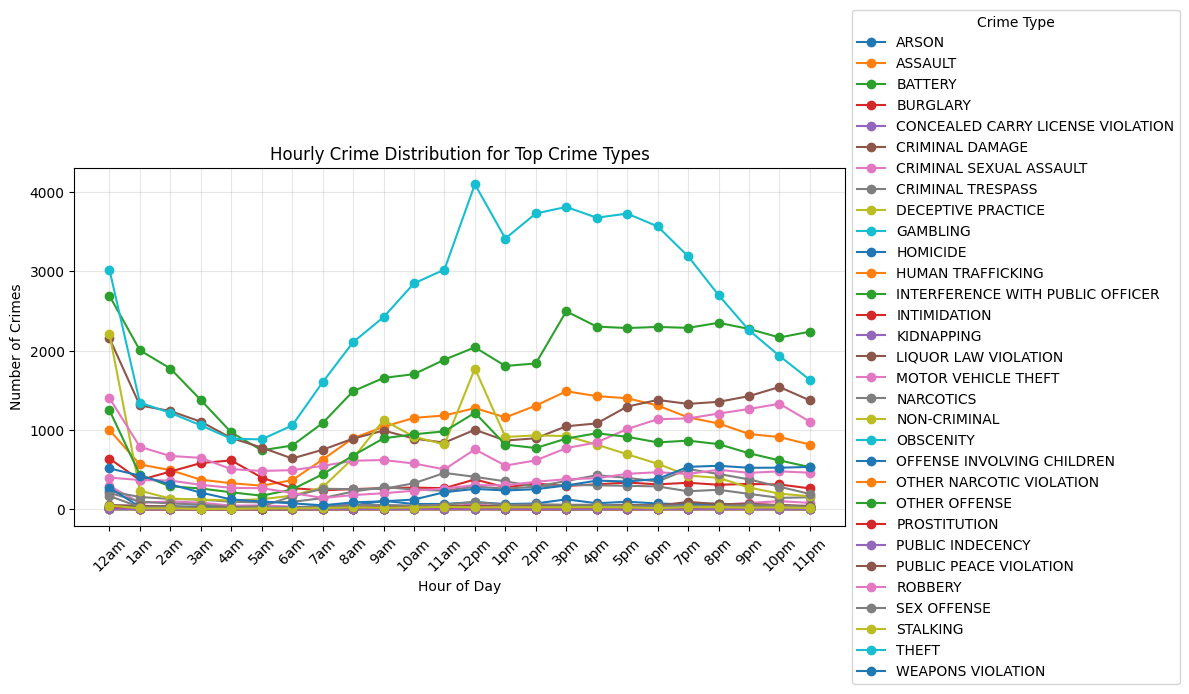

In [10]:
hourly_data = ch.groupby(['Hour', 'Primary Type'])['ID'].count().unstack()

plt.figure(figsize=(12, 6))
hourly_data.plot(marker='o', ax=plt.gca())

plt.xticks(
    ticks=range(0, 24),
    labels=['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am',
            '12pm','1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm'],
    rotation=45
)

plt.title('Hourly Crime Distribution for Top Crime Types')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.grid(alpha=0.3)
plt.legend(title='Crime Type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

<h3>Insight 1:</h3>
<p>The visualization above shows the most active crime type per hour.</br> </br> Key Observations:</br> 1. Peak crime activity occurs during 12pm, at the middle of the day. </br> 2. Low crime activities during early morning, the safest time of the day</br> 3. After  the safest time, the crime rate starts to decline at 7am </br> 4. Crime rate declines at late night </br></br> With this findings, the government can employ safety measures during the peak times mentioned. </p>

<h3>Crime types per Community areas</h3>

In [11]:
crime_diversity = ch.groupby('Community Area')['Primary Type'].nunique().reset_index()
crime_diversity.columns = ['Community Area', 'Crime Diversity']
PerCommunity = ch.groupby('Community Area')[['Latitude', 'Longitude']].mean().reset_index()
crime_diversity = crime_diversity.merge(PerCommunity, on='Community Area')
locations = list(zip(crime_diversity['Latitude'], crime_diversity['Longitude'], crime_diversity['Crime Diversity']))

m = folium.Map(location=[crime_diversity['Latitude'].mean(), crime_diversity['Longitude'].mean()], zoom_start=10)
HeatMap(locations, radius=15, blur=10, max_zoom=1).add_to(m)
m


<h3></br> As the heatmap is analyzed, key findings includes: </h3>
<h3>Insight #2:</h3>
<p>The most busy areas are:</br> 1. South Troy Streeet</br>2. West Haven</br>3. Roseland </p>
<h3></br>Insight #3: </h3>
<p>Most of the Crimes happened the near the bay area, with Elk Grove Village being the outlier</p>




<h3>Locations where domestic where most likely to occur</h3>

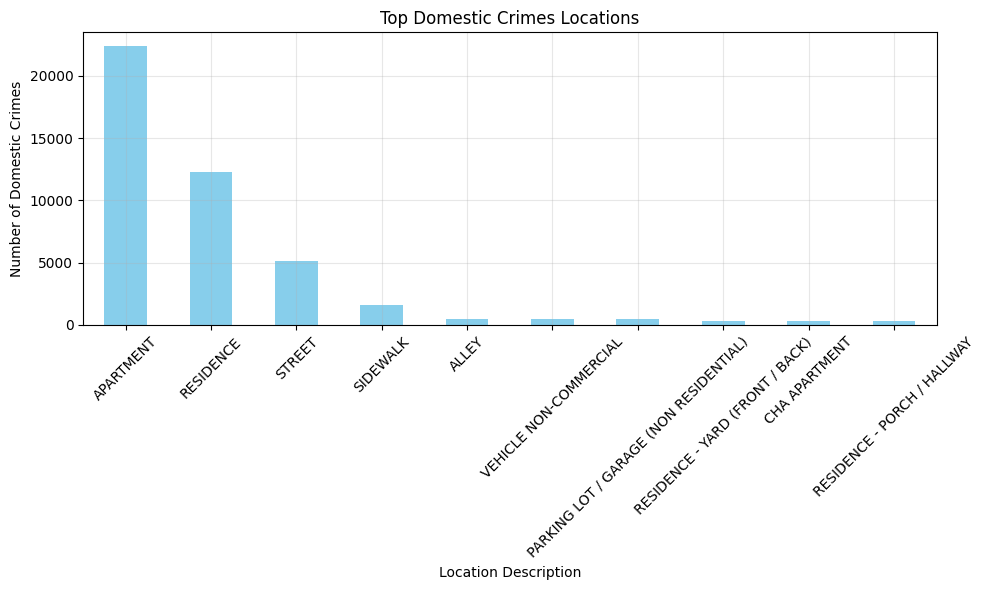

In [12]:
PerLocation = ch.groupby(['Location Description','Domestic'])['ID'].count().reset_index()
PerLocation = PerLocation[PerLocation['Domestic'] == True]
TopLocation = PerLocation.sort_values(by = 'ID',  ascending = False).head(n=10)

TopLocation.plot(
    kind='bar',
    x='Location Description',
    y='ID',
    legend=False,
    figsize=(10,6),
    color='skyblue'
)
plt.title('Top Domestic Crimes Locations')
plt.xlabel('Location Description')
plt.ylabel('Number of Domestic Crimes')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<h3>Insight #4:</h3>
<p>Most of domestic crimes occured at apartments, with a staggering count of 20000 crimes. </p>

<h3>Monthly analysis of Crime categories</h3>

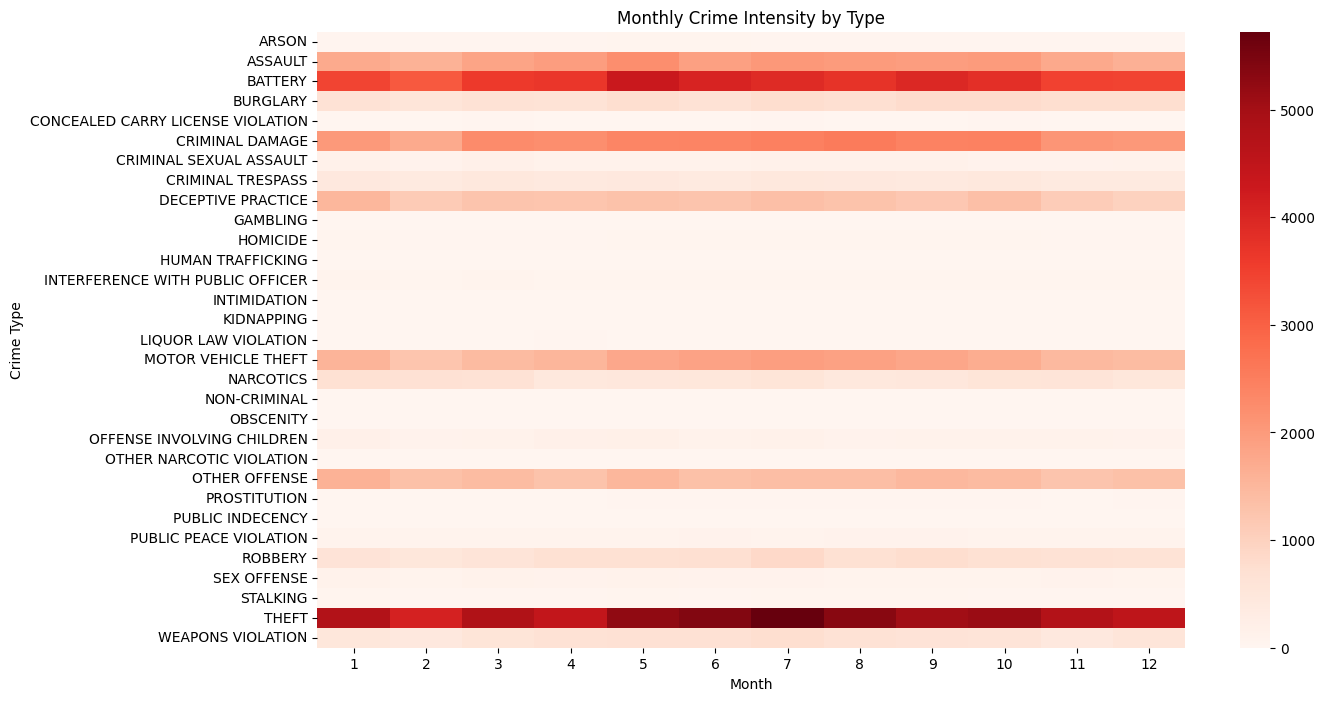

In [13]:
monthly_data = ch.copy()
monthly_grouped = monthly_data.groupby(['Month', 'Primary Type'])['ID'].count().unstack()

plt.figure(figsize=(14,8))
sns.heatmap(monthly_grouped.T, cmap='Reds', annot=False)
plt.title('Monthly Crime Intensity by Type')
plt.xlabel('Month')
plt.ylabel('Crime Type')
plt.show()

<h3>Insight 5:</h3>  
<p>The visualization above shows the monthly distribution of crime types across the year.</br></br>  
Key Observations:</br>  
1. Theft and Assault are consistently high across all months, indicating year-round occurance</br>  
2. Motor Vehicle theft violations show noticeable spikes during mid-year months, suggesting seasonal influence.</br>  
3. Rare crimes such as Human Trafficking and Indicency remain low throughout the year.</br>  
4. Certain crimes like Criminal damage and Deceptive practice peak during summer and holiday months.</br></br>  
</p>

<h3>Insight 6:</h3>  
<p>The chart highlights the variation in crime intensity by type and month.</br></br>  
Key Observations:</br>  
1. December and July show high activity for property-related crimes such as Burglary and Theft.</br>  
2. Violent crimes like Assault and Battery maintain steady levels, with slight increases in warmer months.</br>  
3. Low-frequency crimes such as Gambling remain minimally active across all months.</br></br>  

<h3>Arrest rates per district</h3>

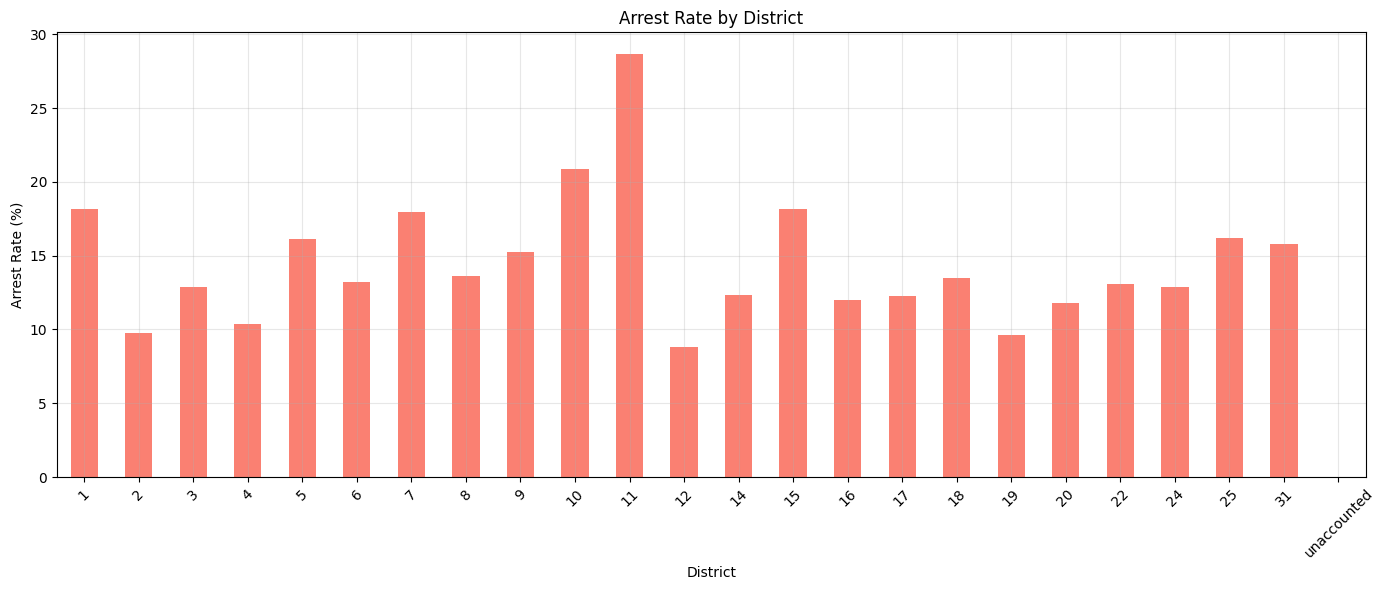

In [14]:
crime_counts = ch.groupby('District')['ID'].count()
arrest_counts = ch[ch['Arrest'] == True].groupby('District')['ID'].count()
arrest_rate = (arrest_counts / crime_counts) * 100
arrest_rate = arrest_rate.sort_index()

arrest_rate.plot(kind='bar', figsize=(14,6), color='salmon')
plt.title('Arrest Rate by District')
plt.xlabel('District')
plt.ylabel('Arrest Rate (%)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<h3>Insight 7:</h3> 
<p>The visualization above shows the arrest rate across different district areas.</br></br> Key Observations:</br>
1. District 11 has the highest arrest rate, suggesting strong enforcement or efficient policing.</br>
2. Disticts 12 and show significantly lower arrest rates.</br>
3. Districts with low arrest rates could be under strain or facing challenges in case resolution.</p>

<h3>Insight 8:</h3> 
<p>The chart highlights inconsistencies in law enforcement effectiveness across districts.</br></br> Key Observations:</br>
1. Arrest rates vary widely, with some districts achieving over 20% while others fall below 10%.</br>
2. Districts with consistently low arrest rates could benefit from improvement programs.</br></p>

<h1>Bivariate Plotting</h1>

<h3>Arrest likelihood per crime type</h3>

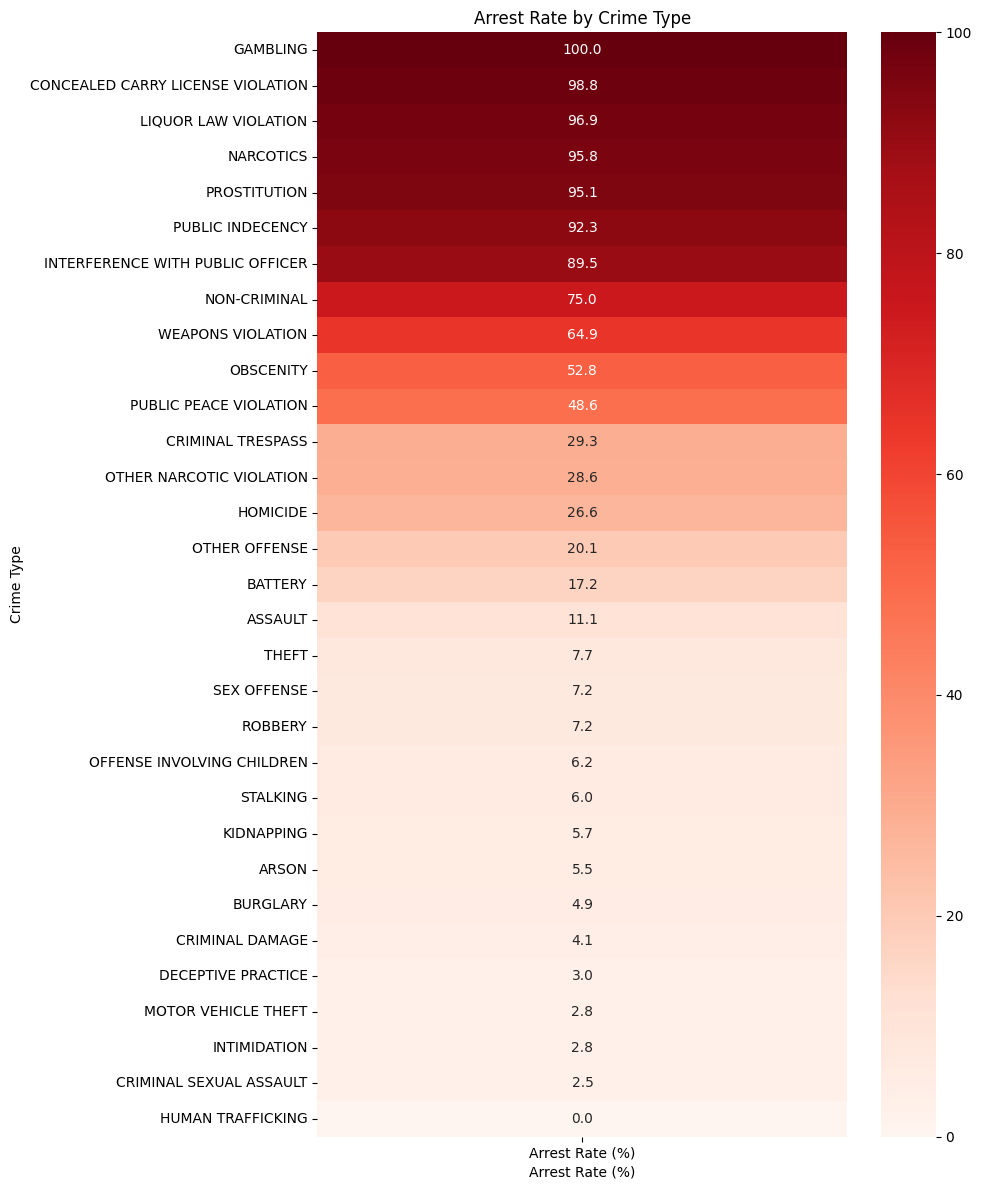

In [15]:
crime_counts = ch.groupby('Primary Type')['ID'].count()
arrest_counts = ch[ch['Arrest'] == True].groupby('Primary Type')['ID'].count()

arrest_rate = (arrest_counts / crime_counts) * 100
arrest_rate = arrest_rate.fillna(0).sort_values(ascending=False)

arrest_ch = arrest_rate.reset_index()
arrest_ch.columns = ['Primary Type', 'Arrest Rate (%)']
arrest_ch.set_index('Primary Type', inplace=True)

plt.figure(figsize=(10,12))
sns.heatmap(arrest_ch, cmap='Reds', annot=True, fmt=".1f")
plt.title('Arrest Rate by Crime Type')
plt.xlabel('Arrest Rate (%)')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

<h3>Insight 9:</h3>  
<p>The visualization above shows the arrest rate distribution across different crime categories.</br></br>  
Key Observations:</br>  
1. Crimes such as Gambling, Carry License Violations, and Liquor Law Violations have arrest rates exceeding 95% which shows strict enforcement.</br>  
2. Crimes like Prostitution, Public Indecency, and Interference with public officers also show high arrest rates implementing active policing in offenses.</br>   
3. Human Trafficking shows a 0% arrest rate, which indicates a serious problem with policies.</br></br>  </p>

<h3>Insight 10:</h3>  
<p>The horizontal bar chart emphasizes low arrest rates among different crimes.</br></br>  
Key Observations:</br>  
1. Crimes like Burglary, Motor Vehicle Theft, and Criminal Damage have arrest rates below 5%, which would affect the peace among ordinary citizens</br>  
2. Violent crimes such as Criminal Sexual Assault and Arson also show arrest rates under 6%, which would mean there is a delay in justice for those affected.</br>  
3.  These low arrest rates could indicate challenges in investigation, which would affect the police and governing unit's creadibility</br></br>  

<h3>Crime types per wards</h3>

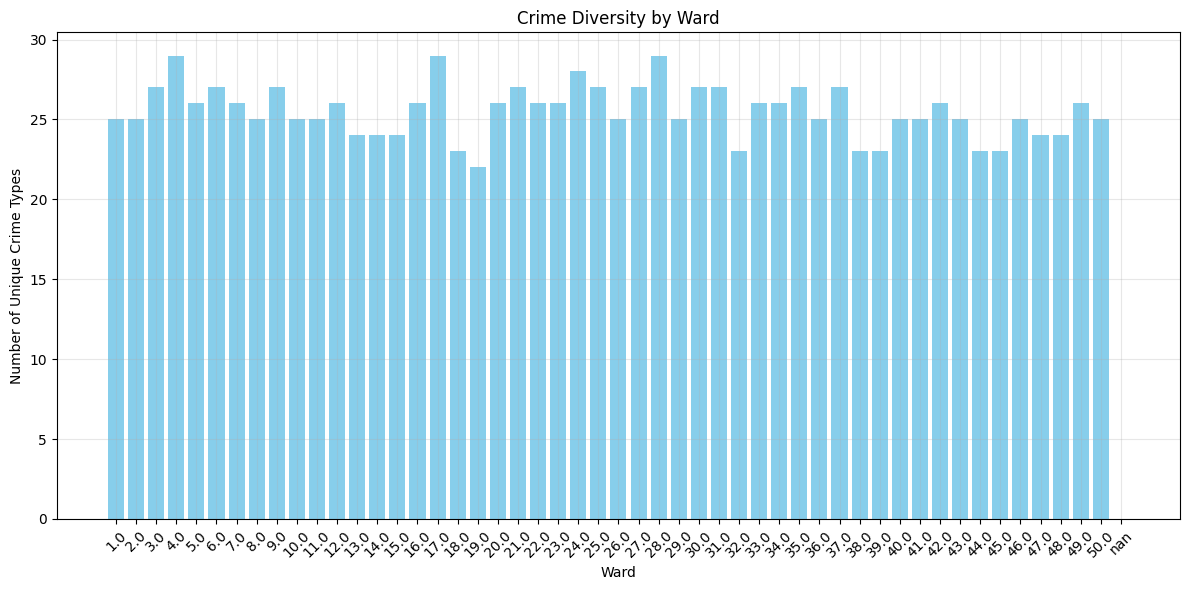

In [16]:
crime_diversity = ch.groupby('Ward')['Primary Type'].nunique().reset_index()
crime_diversity['Ward'] = pd.to_numeric(crime_diversity['Ward'], errors='coerce')
crime_diversity = crime_diversity.sort_values(by='Ward')

plt.figure(figsize=(12,6))
plt.bar(crime_diversity['Ward'].astype(str), crime_diversity['Primary Type'], color='skyblue')
plt.title('Crime Diversity by Ward')
plt.xlabel('Ward')
plt.ylabel('Number of Unique Crime Types')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<h3>Insight 11:</h3>  
<p>The chart reveals distribution of crime diversity across wards.</br></br>  
Key Observations:</br>  
1. Most wards report between 25 to 30 unique crime types, indicating a diverse crime type for Chicago</br>   
2. Wards with lower diversity may be more residential or have limited commercial exposure.</br></br></p>

<h3>Insight 12:</h3>  
<p>Crime diversity can serve as a proxy for urban complexity and enforcement challenges.</br></br>  
Key Observations:</br>  
1. Wards with high crime diversity may face difficulties in preserving peace between wards</br>  
2. These wards should require properly trained staffs</br>  
3. Conversely, wards with low diversity may be used for focused response. </br> </p>

<h3>Crime rates across days of the week</h3>

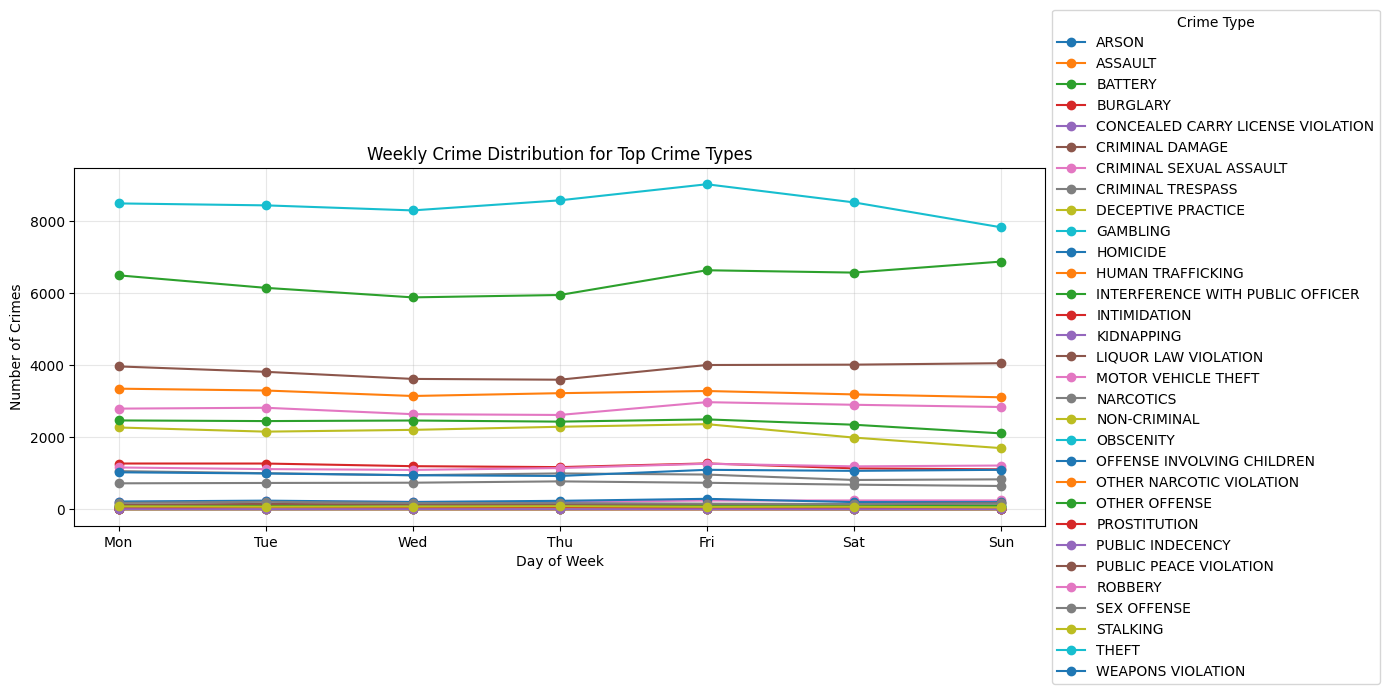

In [17]:
daily_data = ch.groupby(['DayOfWeek', 'Primary Type'])['ID'].count().unstack()

plt.figure(figsize=(14,6))
daily_data.plot(marker='o', ax=plt.gca())

plt.xticks(
    ticks=range(0, 7),
    labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    rotation=0
)

plt.title('Weekly Crime Distribution for Top Crime Types')
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes')
plt.grid(alpha=0.3)
plt.legend(title='Crime Type', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

<h3>Insight 13:</h3>  
<p>The chart reveals temporal patterns in crime occurrence across weekdays and weekends.</br></br>  
Key Observations:</br>  
1. Crimes such as Battery, Arson, and Criminal Damage show consistent activity throughout the week, which means they are less influenced by day-specific behaviors.</br>  
2. Theft and Burglary exhibit noticeable spikes on weekends, indicating opportunistic targeting when residential and commercial areas may be less guarded.</br>  
3. Alcohol-related offenses tend to rise on Fridays and Saturdays, signifying nightlife and social gatherings.</br></br></p>

<h3>Insight 14:</h3>  
<p>Daily fluctuations in crime types reflect behavioral rhythms and enforcement challenges.</br></br>  
Key Observations:</br>  
1. Steady weekday levels of violent crimes suggest social issue that still occur regardless of calendar cycles.</br>  
3. Understanding these patterns allows for proper scheduling of police resources base on hot zones</br></p>

<h3>Domestic Crimes per District</h3>

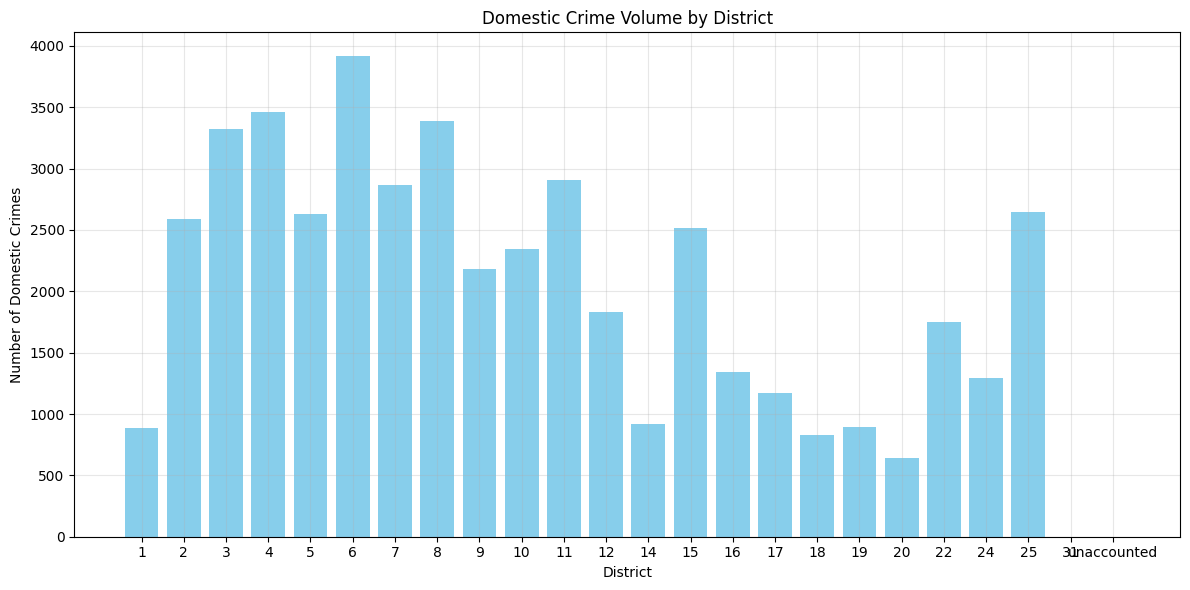

In [18]:
domestic_data = ch[ch['Domestic'] == True]
domestic_counts = domestic_data.groupby('District')['ID'].count()
domestic_counts = domestic_counts.reset_index().sort_values(by='District')

plt.figure(figsize=(12,6))
plt.bar(domestic_counts['District'].astype(str), domestic_counts['ID'], color='skyblue')
plt.title('Domestic Crime Volume by District')
plt.xlabel('District')
plt.ylabel('Number of Domestic Crimes')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<h3>Insight 15:</h3>  
<p>The chart highlights concentrated zones of domestic crime activity across districts.</br></br>  
Key Observations:</br>  
1. A small cluster of districts report high domestic crime volumes, suggesting local or social issues</br>  
2. These districts should benefit from family services, such as community-based counseling hubs.</br>  
3. The variation in volume across districts suggests that domestic crime is not evenly distributed, reinforcing the need for district-specific reinforcement strategies.</br></p>

<h3>Frequency of child-related crimes per ward</h3>

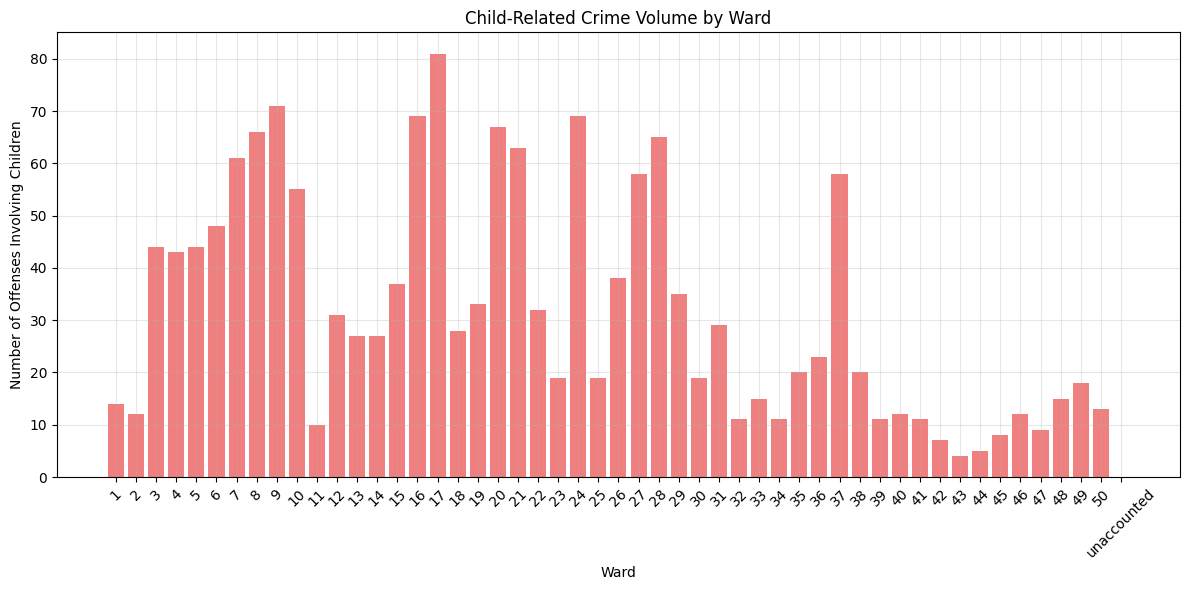

In [19]:
child_crimes = ch[ch['Primary Type'] == 'OFFENSE INVOLVING CHILDREN']
child_counts = child_crimes.groupby('Ward')['ID'].count().reset_index()
child_counts = child_counts.sort_values(by='Ward')  # Sort numerically by ward

plt.figure(figsize=(12,6))
plt.bar(child_counts['Ward'].astype(str), child_counts['ID'], color='lightcoral')
plt.title('Child-Related Crime Volume by Ward')
plt.xlabel('Ward')
plt.ylabel('Number of Offenses Involving Children')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<h3>Insight 16:</h3>  
<p>The chart reveals uneven distribution of child-related offenses across wards.</br></br>  
Key Observations:</br>  
1. A small group of wards report significantly higher volumes of crimes involving children, indicating weak family safety or youth protection.</br>  
2. These high-volume wards should benefit from programs such as school-based outreach, and child welfare programs.</br>  
3. Wards with lower counts may reflect safer environments or potential underreporting, suggesting needs for powerful witness protections</br></p>

<h3>Crime Types prevalent in school zones vs. residential areas</h3>

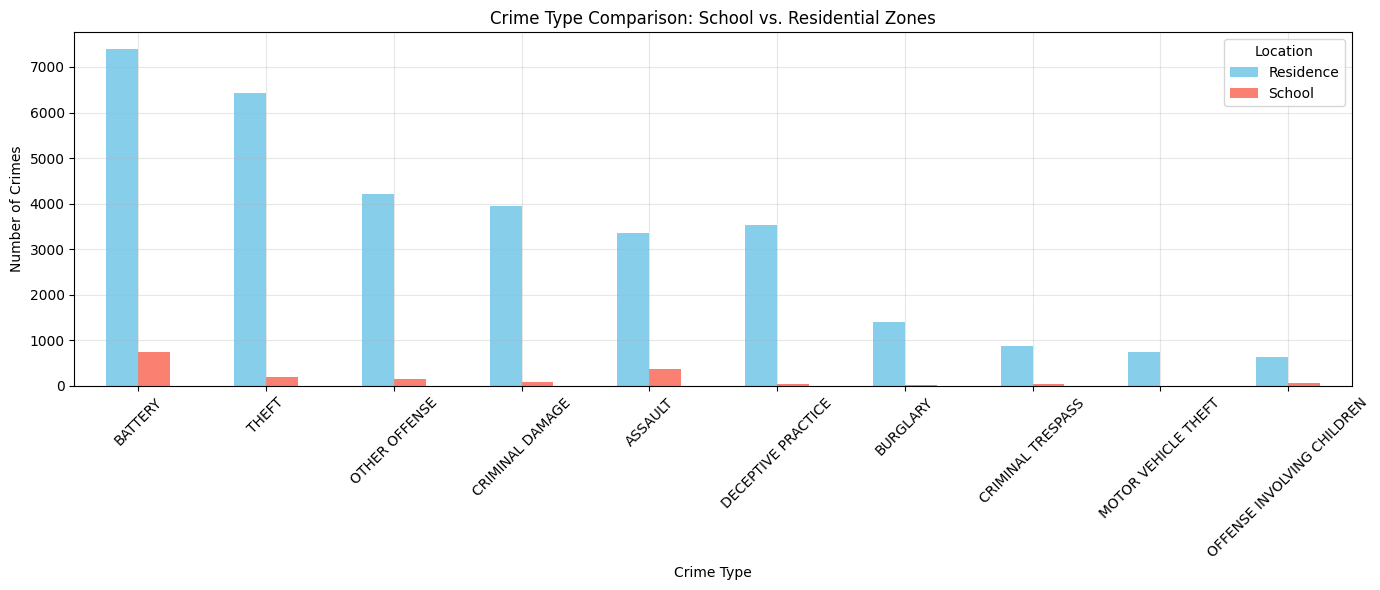

In [20]:
school_locations = ['SCHOOL', 'SCHOOL - PRIVATE BUILDING', 'SCHOOL - PUBLIC BUILDING',
    'COLLEGE / UNIVERSITY - CLASSROOM', 'COLLEGE / UNIVERSITY - GROUNDS',
    'DAY CARE CENTER']

residence_locations = [ 'RESIDENCE', 'RESIDENCE: GROUP', 'RESIDENCE: PRIVATE', 'RESIDENCE: SHELTER',
    'RESIDENCE - PORCH / HALLWAY', 'DRIVEWAY - RESIDENTIAL',
    'CHA APARTMENT', 'CHA HALLWAY', 'CHA PLAYGROUND', 'CHA STAIRWELL',
    'CHA COURTYARD', 'CHA COMMUNITY CENTER', 'CHA PARKING LOT / GARAGE / OTHER PROPERTY']

filtered = ch[ch['Location Description'].isin(school_locations + residence_locations)]
filtered['Location Category'] = filtered['Location Description'].apply(
    lambda x: 'School' if x in school_locations else 'Residence'
)

crime_counts = filtered.groupby(['Primary Type', 'Location Category'])['ID'].count().reset_index()
crime_counts.columns = ['Crime Type', 'Location', 'Count']

pivoted = crime_counts.pivot(index='Crime Type', columns='Location', values='Count').fillna(0)
top_crimes = pivoted.sum(axis=1).sort_values(ascending=False).head(10).index
pivoted = pivoted.loc[top_crimes]

pivoted.plot(kind='bar', figsize=(14,6), color=['skyblue', 'salmon'])
plt.title('Crime Type Comparison: School vs. Residential Zones')
plt.xlabel('Crime Type')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.legend(title='Location')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<h3>Insight 17:</h3>  
<p>The chart reveals that residential zones experience significantly higher volumes of property and personal crimes compared to school zones.</br></br>  
Key Observations:</br>  
1. Crimes such as Assault, Burglary, Theft are notably more frequent in residential areas, indicating lower environmental controls.</br>  
2. These high-crime residential zones should benefit from neighborhood programs,surveillance infrastructure.</br>  
3. The chart implies that residential environments are more exposed to personal offenses, affecting safety and family support.</br></p>

<h3>Insight 18:</h3>  
<p>The chart highlights that school zones, while lower in overall crime volume, concentrate behavioral and contraband-related offenses.</br></br>  
Key Observations:</br>    
2. These patterns suggest the need for school-based behavioral support programs</br>  
3. The presence of these offenses in educational settings may affect the importance of early intervention </br></p>

<h3>Pie Chart:Comparison of number of Juvenile crimes vs. Adult crimes</h3>

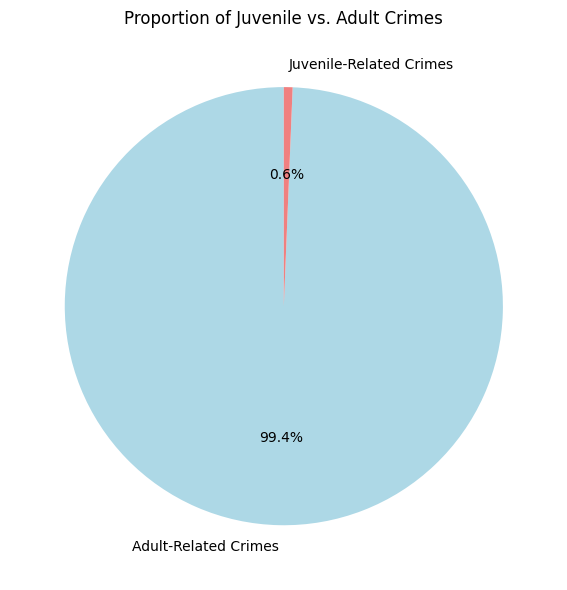

In [21]:
juvenile_types = [
    'OFFENSE INVOLVING CHILDREN',
    'CHILD ABUSE',
    'CHILD PORNOGRAPHY'
]

ch['Juvenile Crime'] = ch['Primary Type'].isin(juvenile_types)

crime_counts = ch['Juvenile Crime'].value_counts()
labels = ['Adult-Related Crimes', 'Juvenile-Related Crimes']
colors = ['lightblue', 'lightcoral']

plt.figure(figsize=(6,6))
plt.pie(crime_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Proportion of Juvenile vs. Adult Crimes')
plt.tight_layout()
plt.show()

<h3>Insight 19:</h3>  
<p>The chart reveals that juvenile-related crimes represent an extremely small fraction of total reported offenses.</br></br>  
Key Observations:</br>  
1. With only 0.1% of crimes involving juveniles, the data suggests either a genuinely low incidence or potential underreporting of youth-related offenses.</br>  
2. This minimal share may reflect limited detection, reporting barriers, or classification gaps in how juvenile involvement is recorded.</br>  
3. Despite the low volume, juvenile crimes carry high social impact, warranting proactive measures such as school-based prevention programs, youth counseling, and improved reporting mechanisms to ensure early intervention.</br></p>

<h3>Chicago Crime hotspots by latitude and longitude</h3>

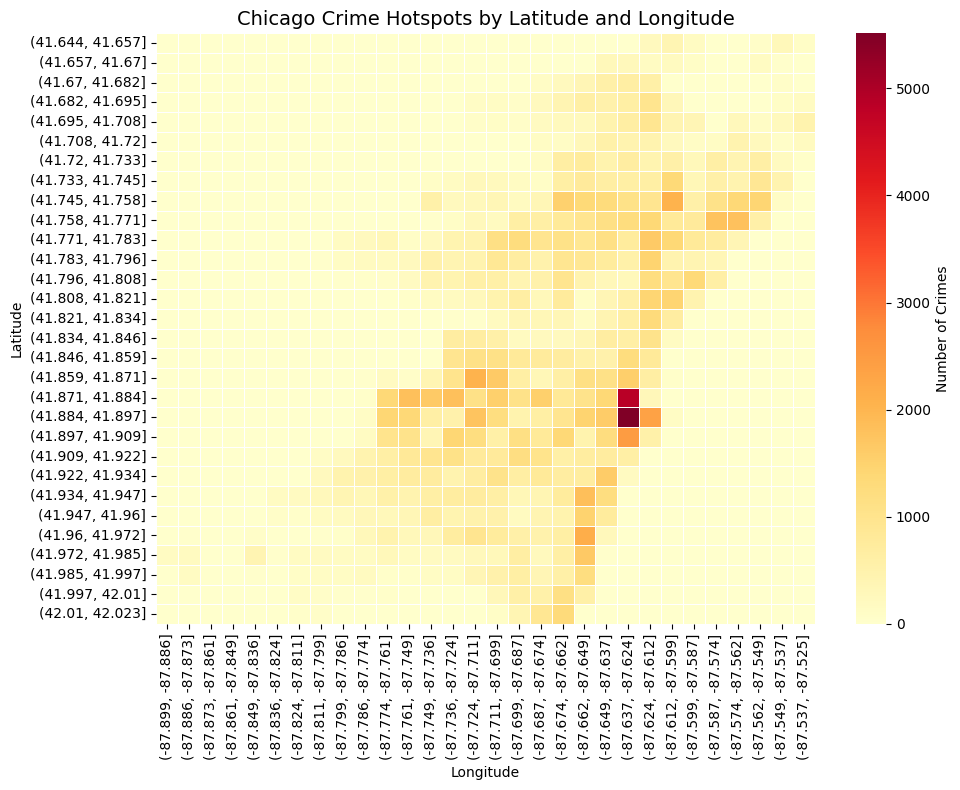

In [22]:
ch[['Latitude', 'Longitude']] = ch['Location'].str.strip('()').str.split(',', expand=True)
ch['Latitude'] = ch['Latitude'].astype(float)
ch['Longitude'] = ch['Longitude'].astype(float)

chicago_ch = ch[(ch['Latitude'] > 41.6) & (ch['Latitude'] < 42.1) &
                (ch['Longitude'] > -87.9) & (ch['Longitude'] < -87.5)]

heatmap_data = chicago_ch.groupby(
    [pd.cut(chicago_ch['Latitude'], 30), 
     pd.cut(chicago_ch['Longitude'], 30)]
).size().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={'label': 'Number of Crimes'}
)

plt.title('Chicago Crime Hotspots by Latitude and Longitude', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

<h3>Insight 20:</h3>  
<p>The heatmap reveals concentrated crime activity in specific geographic zones during late-night and early-morning hours.</br></br>  
Key Observations:</br>  
1. The most intense hotspot aligns with coordinates near N hacker st. and W randolph st. areas associated with elevated crime rates and limited public safety infrastructure.</br></br></p>
<h5>Google maps search results:</h5>

![Hotspot image](hotspot.png)

<h1>Correlational Analysis</h1>

<h3>Correlation between time of the day and the location of the crime</h3>

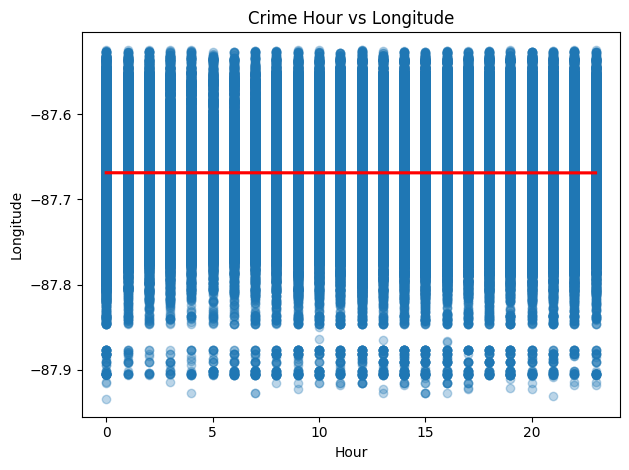

In [23]:
sns.regplot(data=ch, x='Hour', y='Longitude', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Crime Hour vs Longitude')
plt.tight_layout()
plt.show()

<h3>Insight 21:</h3>  
<p>The scatter plot reveals a consistent concentration of crimes around a narrow longitude band throughout all hours of the day.</br></br>  
Key Observations:</br>  
1. The red regression line suggests minimal variation in longitude across time, indicating that most crimes occur within a fixed east-west corridor of the city.</br>   
2. This spatial consistency implies that crime timing may be influenced more by social rhythms (e.g., business hours, nightlife) than geographic dispersion, reinforcing the need for time-targeted policing in high-density zones.</br></p>

<h3>Correlation between day of the week and crime location</h3>

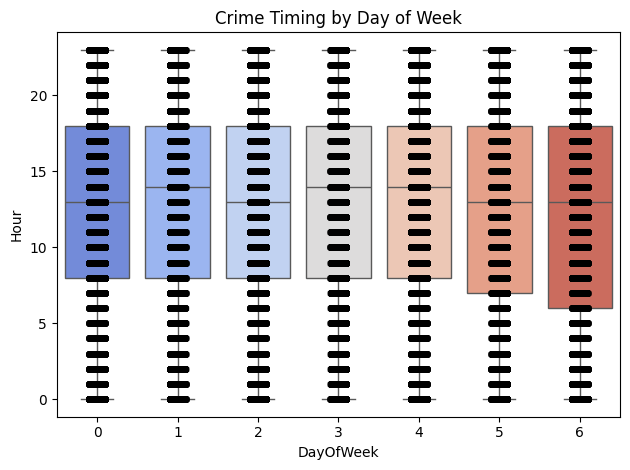

In [24]:
sns.boxplot(data=ch, x='DayOfWeek', y='Hour', palette='coolwarm')
sns.stripplot(data=ch, x='DayOfWeek', y='Hour', color='black', alpha=0.2)
plt.title('Crime Timing by Day of Week')
plt.tight_layout()
plt.show()

<h3>Insight 22:</h3>  
<p>Crimes on weekends tend to happen later in the day, especially at night.</br></br>  
Key Observations:</br>  
1. On Saturdays and Sundays crimes are more likely to occur during the late evening and early morning hours.</br>  
2. This pattern likely reflects the impact of nightlife, parties, and fewer people watching public spaces during those hours.</br>  
3. To stay ahead of this trend, police and safety teams should focus more on late-night patrols in busy weekend areas like bars, clubs, and entertainment zones.</br></p>

<h3>Insight 23:</h3>  
<p>Crimes during weekdays mostly happen in the afternoon and early evening.</br></br>  
Key Observations:</br>  
1. From Monday to Friday, most crimes happen between 12 PM and 7 PM, when people are commuting, working, or attending school.</br>  
2. These crimes seem to follow daily routines, happening when streets and public places are busiest.</br>  
3. To reduce risk, safety efforts should focus on these hours—especially around transit stops, schools, and business areas.</br></p>

<h1>Multivariate Analysis</h1>

<h3>Crime counts per Location</h3>

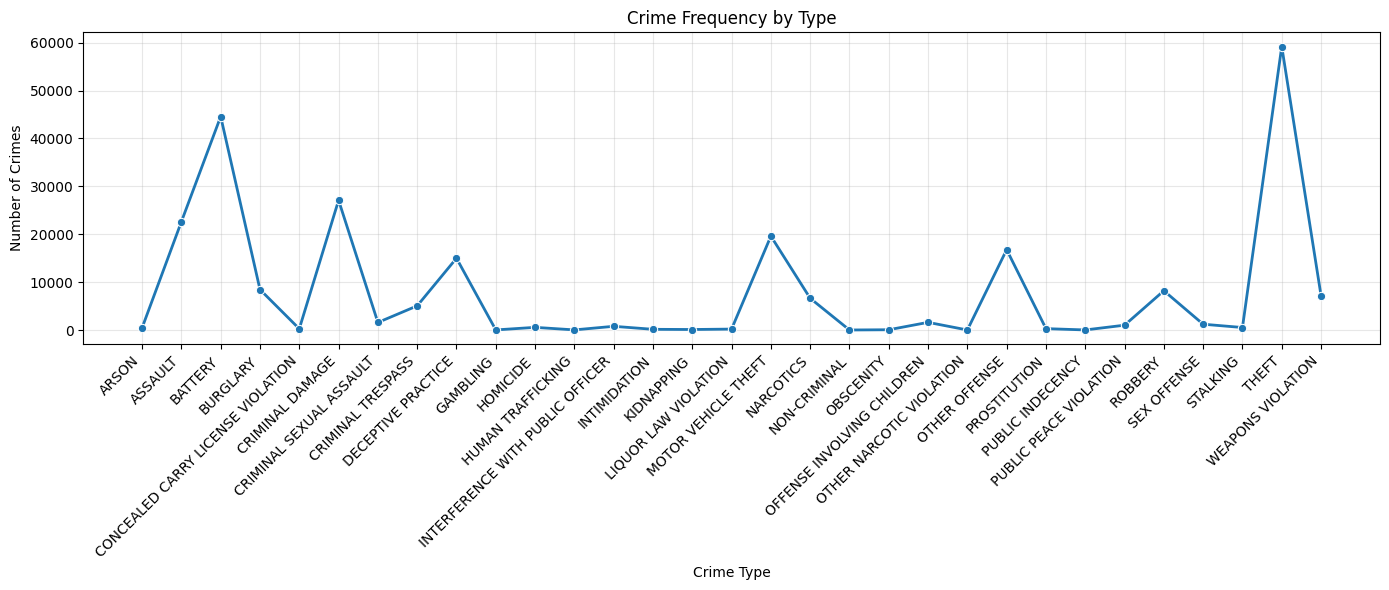

In [25]:
crime_counts = ch['Primary Type'].value_counts().reset_index()
crime_counts.columns = ['Crime Type', 'Count']

crime_counts = crime_counts.sort_values(by='Count', ascending=False)

plt.figure(figsize=(14, 6))
sns.lineplot(data=crime_counts, x='Crime Type', y='Count', marker='o', linewidth=2)

plt.title('Crime Frequency by Type')
plt.xlabel('Crime Type')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<h3>Insight 24:</h3>  
<p>The chart shows that some types of crime happen far more often than others in Chicago.</br></br>  
Key Observations:</br>  
1. Theft and battery are the most common crimes , with thousands of cases reported which these stand out clearly at the top of the chart.</br>  
2. Crimes like narcotics violations and criminal damage also appear frequently, suggesting ongoing issues with drug-related activity and property destruction.</br>  
3. On the other end, crimes such as human trafficking, gambling, and arson are much less common, with very few reported cases.</br>  
4. This wide gap between high-frequency and low-frequency crimes shows where most law enforcement resources are likely focused—and where quieter but serious crimes may need more attention.</br></p>

<h3>Seasonal Variation in Crime Frequency and Arrest Rate (Top 6 Crime Types)</h3>

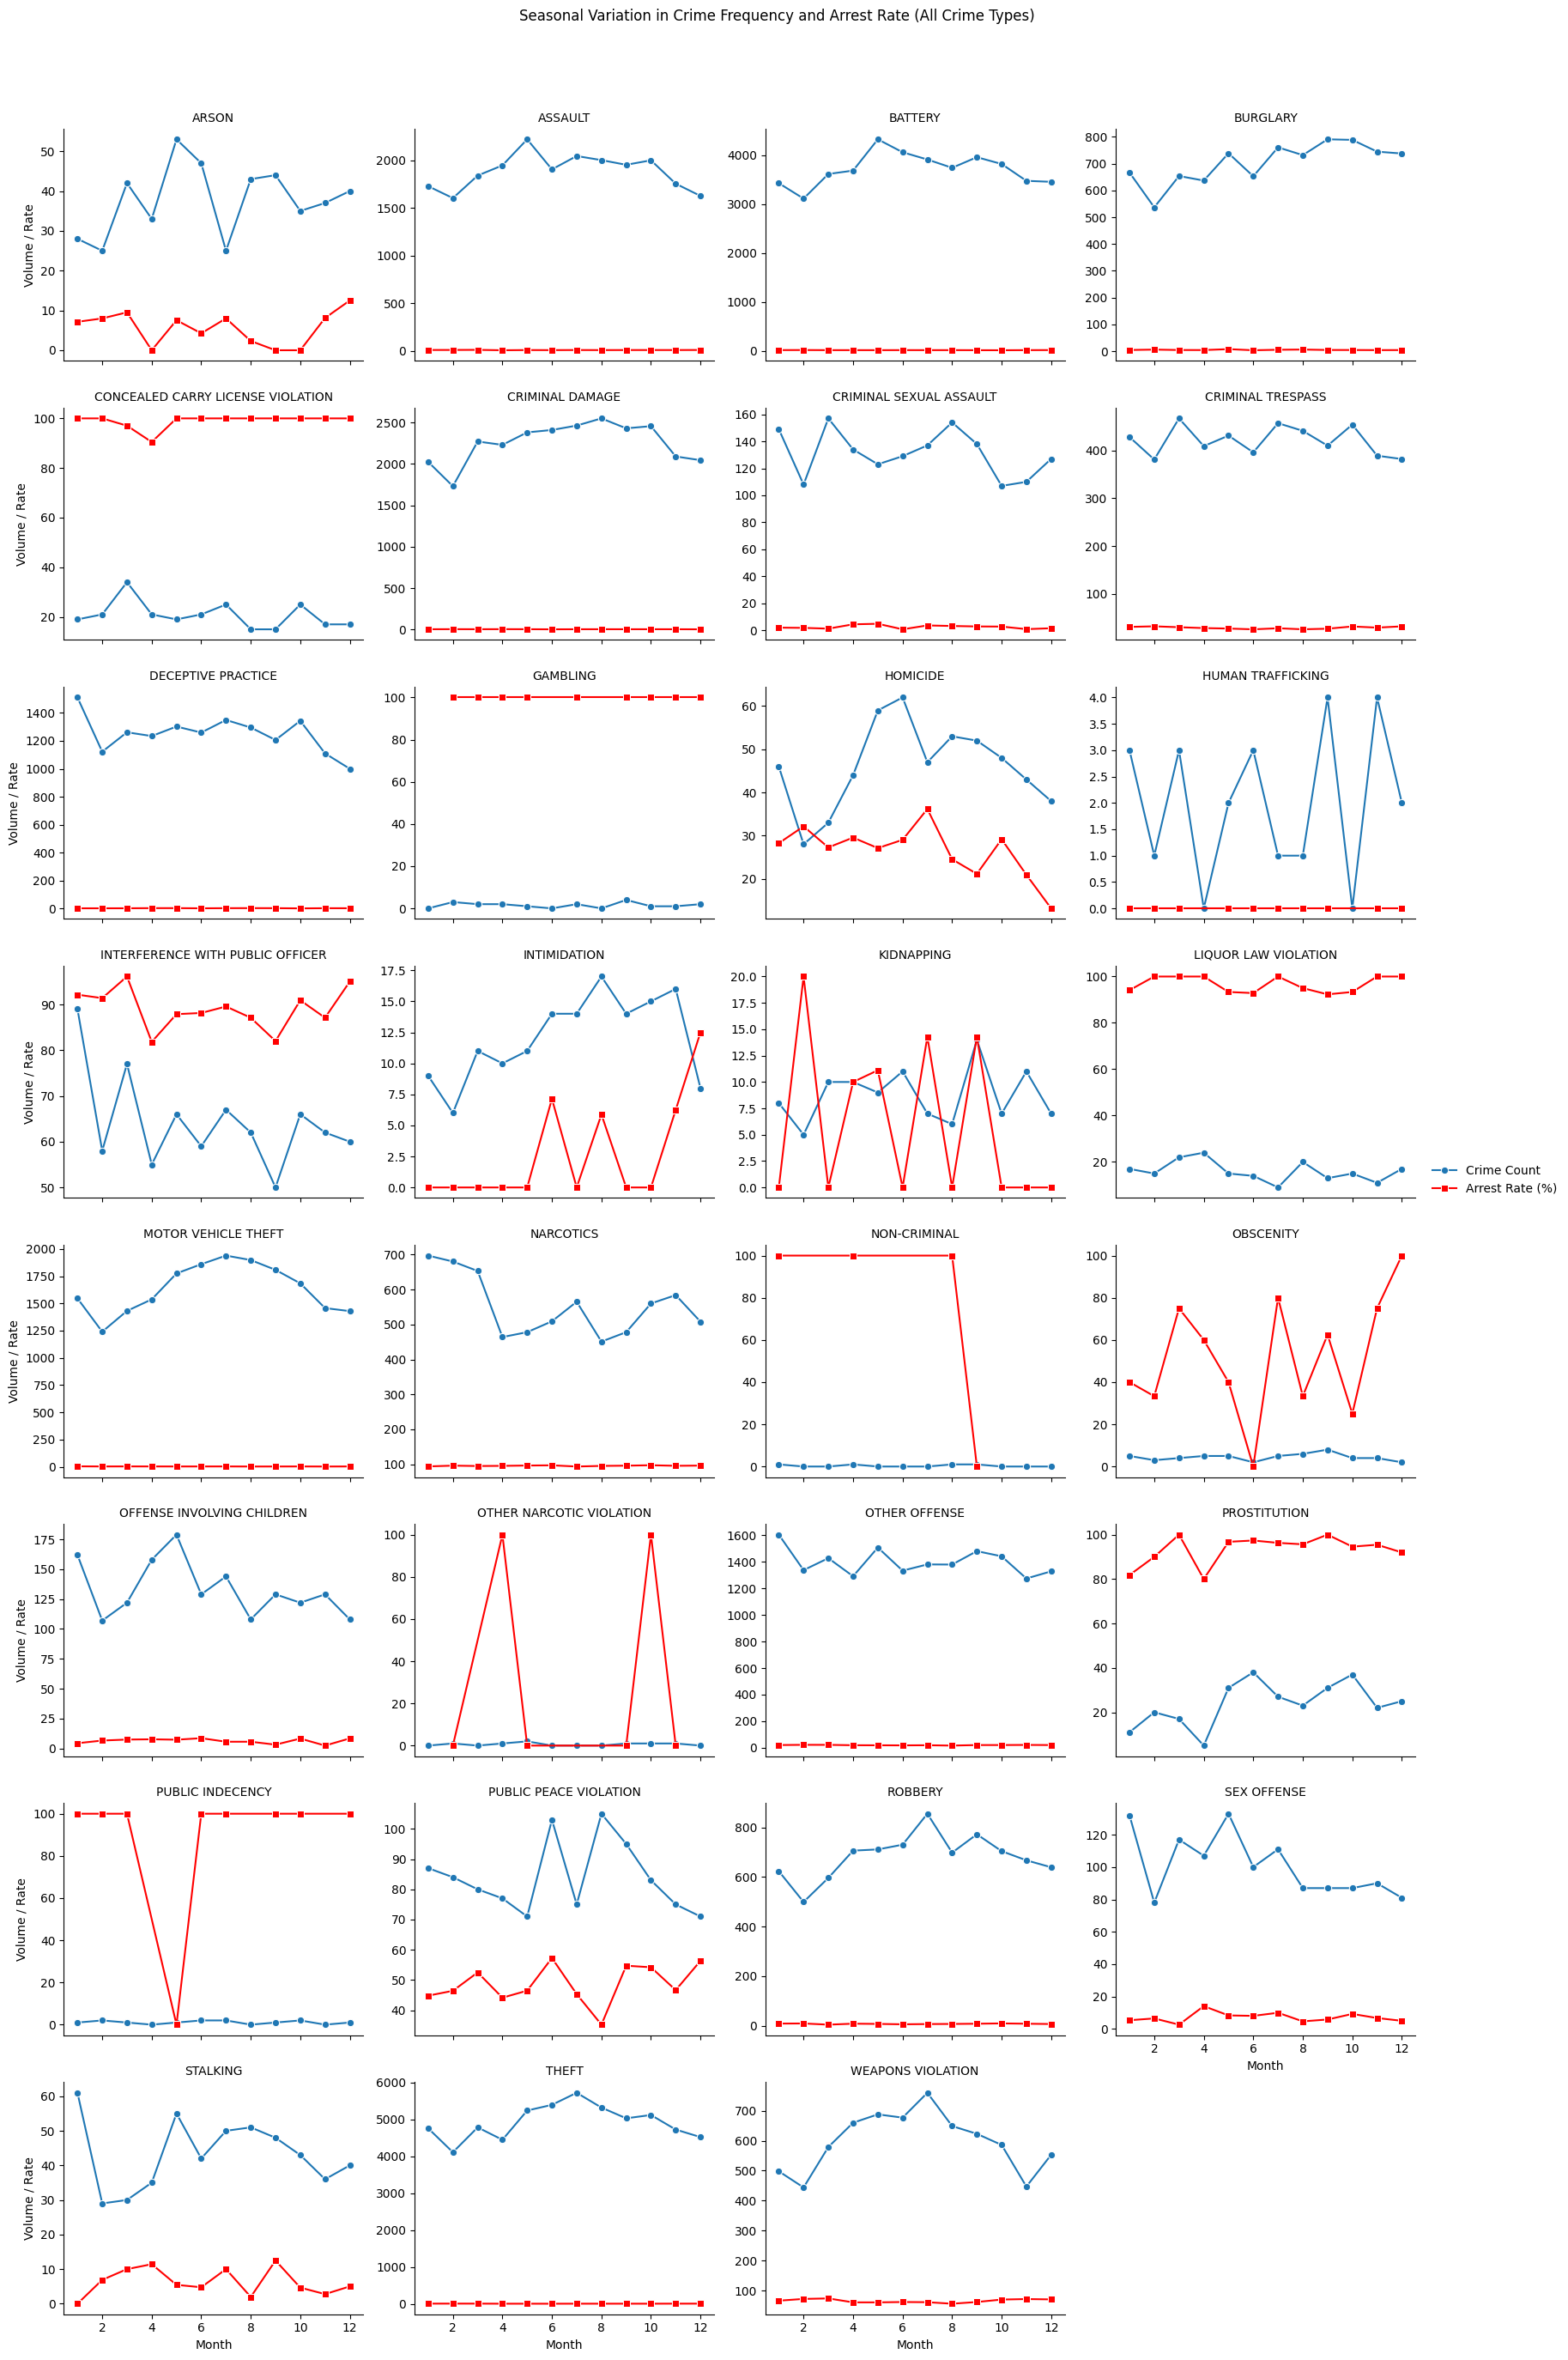

In [26]:
ch_filtered = ch.dropna(subset=['Month', 'Primary Type', 'Arrest'])

# Step 2: Group by Month and Crime Type for total counts
monthly_counts = ch_filtered.groupby(['Month', 'Primary Type'])['ID'].count().reset_index(name='Crime Count')

# Step 3: Group by Month and Crime Type for arrests only
monthly_arrests = ch_filtered[ch_filtered['Arrest'] == True].groupby(['Month', 'Primary Type'])['ID'].count().reset_index(name='Arrest Count')

# Step 4: Merge and calculate arrest rate
monthly_merged = pd.merge(monthly_counts, monthly_arrests, on=['Month', 'Primary Type'], how='left')
monthly_merged['Arrest Count'] = monthly_merged['Arrest Count'].fillna(0)
monthly_merged['Arrest Rate (%)'] = (monthly_merged['Arrest Count'] / monthly_merged['Crime Count']) * 100

# Step 5: Plot using FacetGrid for all crime types
g = sns.FacetGrid(monthly_merged, col='Primary Type', col_wrap=4, height=3.5, aspect=1.2, sharey=False)
g.map_dataframe(sns.lineplot, x='Month', y='Crime Count', label='Crime Count', marker='o')
g.map_dataframe(sns.lineplot, x='Month', y='Arrest Rate (%)', label='Arrest Rate (%)', marker='s', color='red')

# Step 6: Final touches
g.set_titles('{col_name}')
g.set_axis_labels('Month', 'Volume / Rate')
g.add_legend()
plt.subplots_adjust(top=0.93)
g.fig.suptitle('Seasonal Variation in Crime Frequency and Arrest Rate (All Crime Types)')
plt.show()

<h3>Insight 25:</h3>  
<p>The chart reveals that theft and burglary tend to spike during specific months, especially in summer and winter.</br></br>  
Key Observations:</br>  
1. Theft cases rise sharply in July and December, aligning with vacation and holiday seasons when homes and stores may be more vulnerable.</br>  
2. Burglary follows a similar pattern, with noticeable increases in warmer months, suggesting seasonal opportunities for property crimes.</br>  
3. Despite these peaks, arrest rates for both crimes remain consistently low often below 10%, indicating limited resolution.</br>  
4. These trends highlight the need for targeted prevention during high-risk months, especially in residential and retail zones.</br></p>

<h3>Insight 26:</h3>  
<p>Battery and assault maintain a steady presence throughout the year, but enforcement varies month to month.</br></br>  
Key Observations:</br>  
1. Unlike property crimes, battery and assault do not show strong seasonal spikes as they occur consistently across all months.</br>   
2. The huge gap between steady crime volume and low arrest rates may reflect resource allocation or investigative challenges.</br></p>

<h3>Insight 27:</h3>  
<p>Criminal damage incidents increase mid-year, but arrests remain rare.</br></br>  
Key Observations:</br>  
1. Reports of criminal damage such as vandalism or property destruction peaks in June and September.</br>  
2. These months may collide with school breaks, protests, or outdoor events that raise risk.</br>  
3. Despite the rise in cases, arrest rates stay  0, indicating difficulty in identifying or apprehending suspects.</br>  
4. This gap suggests a need for better surveillance or community reporting during high-activity periods.</br></p>

<h3>Insight 28:</h3>  
<p>Narcotics-related crimes appear frequently, but arrest data is missing from the chart.</br></br>  
Key Observations:</br>  
1. Narcotics violations show consistent activity across months, with slight decrease in March and August.</br>  
2. Unlike other crime types, no arrest rate line is shown, which may indicate missing data or exclusion from this analysis.</br>  </p>

<h3>Insight 29:</h3>  
<p>Seasonal crime patterns don’t always match seasonal enforcement.</br></br>  
Key Observations:</br>  
1. Several crimes like theft, burglary, and criminal damage which shows clear seasonal spikes.</br>  
2. Yet arrest rates often remain flat or inconsistent, suggesting that enforcement doesn’t always respond to seasonal shifts.</br>  
3. Aligning enforcement with seasonal trends could improve resolution rates and public safety.</br></p>

<h3>Insight 30:</h3>  
<p>Even high-frequency crimes can have low arrest rates, revealing enforcement gaps.</br></br>  
Key Observations:</br>  
1. Theft and battery are among the most reported crimes, yet their arrest rates are among the lowest.</br>  
2. This contrast suggests that volume alone doesn’t guarantee resolution as some crimes are harder to investigate or prosecute.</br>  
3. Crimes with low arrest rates may require different strategies, such as community engagement or forensic support.</br> </p>


<h1>Geo-spatial Visualization</h1>

<h3>Mapping FBI crime codes per Community</h3>

In [27]:
fbi_diversity = ch.groupby('Community Area')['FBI Code'].nunique().reset_index()
fbi_diversity.columns = ['Community Area', 'FBI Code Diversity']

PerCommunity = ch.groupby('Community Area')[['Latitude', 'Longitude']].mean().reset_index()
fbi_diversity = fbi_diversity.merge(PerCommunity, on='Community Area')

locations = list(zip(
    fbi_diversity['Latitude'],
    fbi_diversity['Longitude'],
    fbi_diversity['FBI Code Diversity']
))

m = folium.Map(
    location=[fbi_diversity['Latitude'].mean(), fbi_diversity['Longitude'].mean()],
    zoom_start=10
)
HeatMap(locations, radius=15, blur=10, max_zoom=1).add_to(m)
m.save('fbi_map.html')
m

<h3>Insight 31:</h3>  
<p>Some neighborhoods experience a wider variety of federal crime types than others.</br></br>  
Key Observations:</br>  
1. Community areas like 290 and 289 show high diversity in FBI crime codes, meaning they deal with many different types of offenses.</br>  
2. This variety could indicate complex social challenges, requiring more flexible and multi-agency responses.</br>  
3. Areas with low diversity may still face serious issues, but they tend to be concentrated around fewer crime types.</br></p>

<h3>Insight 32:</h3>  
<p>Federal crime diversity is not evenly spread across Chicago.</br></br>  
Key Observations:</br>  
1. The heatmap shows clear hotspots where multiple FBI crime codes cluster, especially in central and western zones.</br>  
2. These clusters suggest that certain regions face layered criminal activity, from property crimes to violent offenses.</br>  
3. Mapping this diversity helps identify which communities may need broader support beyond traditional policing.</br></p>

<h3>Insight 33:</h3>  
<p>Geographic patterns reveal where law enforcement may face the most complexity.</br></br>  
Key Observations:</br>  
1. Areas with high FBI code diversity likely require officers to handle a wider range of situations—from drug violations to weapon offenses.</br>  
2. This complexity can stretch local resources and affect response times or case resolution.</br> </p>

<h3>Domestic Crime volume by community area</h3>

In [28]:
domestic_data = ch[ch['Domestic'] == True]
domestic_counts = domestic_data.groupby('Community Area')['ID'].count().reset_index()
domestic_counts.columns = ['Community Area', 'Domestic Crime Count']
community_coords = ch.groupby('Community Area')[['Latitude', 'Longitude']].mean().reset_index()

domestic_map_data = pd.merge(domestic_counts, community_coords, on='Community Area')
locations = list(zip(
    domestic_map_data['Latitude'],
    domestic_map_data['Longitude'],
    domestic_map_data['Domestic Crime Count']
))


m = folium.Map(
    location=[domestic_map_data['Latitude'].mean(), domestic_map_data['Longitude'].mean()],
    zoom_start=10
)
HeatMap(locations, radius=15, blur=10, max_zoom=1).add_to(m)
m.save('domestic_map.html')
m

<h3>Insight 34:</h3>  
<p>Domestic crimes are heavily concentrated near the lakefront and central neighborhoods.</br></br>  
Key Observations:</br>  
1. The heatmap shows intense activity in areas like the Near North Side, Loop, and South Shore, suggesting higher domestic crime volumes in densely populated zones.</br>  
2. These regions often contain a mix of residential buildings and transitional housing, which may contribute to household stress or conflict.</br></p>

<h3>Insight 35:</h3>  
<p>Western and far-south neighborhoods show lower domestic crime density, but that doesn’t mean lower risk.</br></br>  
Key Observations:</br>  
1. Some areas show minimal heatmap intensity, which may reflect underreporting or limited access to reporting channels.</br>  
2. Lower visibility on the map could mask real issues, especially in communities with cultural or economic barriers to seeking help.</br>  /p>